# **Candidate no:291736** 

# Python version:3.12.7

# **Importing necessary libraries for analysis**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Setting up the notebook with package versions
print("Notebook uses Python version: 3.12.7")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Notebook uses Python version: 3.12.7
Pandas version: 2.2.2
NumPy version: 1.26.4
Matplotlib version: 3.9.2
Seaborn version: 0.13.2


# **1.Data Cleaning and Wrangling**

## Function to load data

In [4]:
# Function to clean and concatenate large datasets
def clean_and_concatenate_chunks(file_path, chunksize=100000, subset=None):
    """
    Reads a large CSV file in chunks, cleans each chunk, and concatenates the results.
    :param file_path: str, path to the CSV file
    :param chunksize: int, size of each chunk to load
    :return: DataFrame, concatenated cleaned data
    """
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        if subset:
            chunk.dropna(subset=subset, inplace=True)  # Drop rows with missing values in specified columns
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

# Function to read data
def read_data(name_dir):
    """
    Reads all required datasets from the specified directory.
    :param name_dir: str, path to the directory containing datasets
    :return: dict, containing all dataframes
    """
    files = {
        'courses': f'{name_dir}/courses.csv',
        'assessments': f'{name_dir}/assessments.csv',
        'vle': f'{name_dir}/vle.csv',
        'studentInfo': f'{name_dir}/studentInfo.csv',
        'studentRegistration': f'{name_dir}/studentRegistration.csv',
        'studentAssessment': f'{name_dir}/studentAssessment.csv',
        'studentVle': f'{name_dir}/studentVle.csv'
    }

    data = {
        'courses': pd.read_csv(files['courses']),
        'assessments': pd.read_csv(files['assessments']),
        'vle': clean_and_concatenate_chunks(files['vle'], chunksize=1000, subset=['activity_type']),
        'studentInfo': pd.read_csv(files['studentInfo']),
        'studentRegistration': pd.read_csv(files['studentRegistration']),
        'studentAssessment': pd.read_csv(files['studentAssessment']),
        'studentVle': clean_and_concatenate_chunks(files['studentVle'], chunksize=100000, subset=['sum_click'])
    }

    return data
# Function to merge large datasets in batches
def batch_merge(left_df, right_df, on, how='left', chunksize=50000):
    """
    Perform batch-wise merging for large datasets.
    :param left_df: DataFrame, the left DataFrame to merge
    :param right_df: DataFrame, the right DataFrame to merge
    :param on: list, columns to merge on
    :param how: str, type of merge (default is 'left')
    :param chunksize: int, number of rows to process in each chunk
    :return: DataFrame, merged result
    """
    result_chunks = []
    for start in range(0, len(left_df), chunksize):
        chunk = left_df.iloc[start:start + chunksize]
        merged_chunk = chunk.merge(right_df, on=on, how=how)
        result_chunks.append(merged_chunk)
    return pd.concat(result_chunks, ignore_index=True)


# Define directory path
fname = "OULAD"

# Read data using the function
print("Data loaded sucessfully")
data = read_data(fname)

Data loaded sucessfully


# Extract datasets 

In [5]:
# Extract datasets
courses = data['courses']
assessments = data['assessments']
vle = data['vle']
student_info = data['studentInfo']
student_registration = data['studentRegistration']
student_assessment = data['studentAssessment']
student_vle = data['studentVle']


In [6]:
# Cleaning and Wrangling the Data
print("Cleaning and Wrangling Data...")
# Merge studentVle with vle to enrich with activity_type
print("Merging studentVle with vle dataset...")
enriched_student_vle = student_vle.merge(vle, on=['id_site', 'code_module', 'code_presentation'], how='left')


Cleaning and Wrangling Data...
Merging studentVle with vle dataset...


# **2. Exploratory Data Analysis**
- Top 5 modules chosen by students
- Top 5 modules with the highest average score
- Top 5 modules with the lowest average score
- Top 5 modules with the most number of fails
- Age distribution of students
- Weekly activity patterns of students' interaction with the VLE

In [7]:
# Merge datasets for comprehensive analysis
student_data = pd.merge(student_info, student_assessment, on=['id_student'], how='inner')
student_data = pd.merge(student_data, assessments, on=['id_assessment'], how='inner')

# Rename duplicate columns for clarity
student_data.rename(columns={'code_module_x': 'code_module', 'code_presentation_x': 'code_presentation'}, inplace=True)

# Analysis 1: Top 5 modules chosen by students
top_modules = (
    student_info['code_module']
    .value_counts()
    .head(5)
    .reset_index()
    .rename(columns={'index': 'code_module', 'code_module': 'student_count'})
)

# Analysis 2: Top 5 modules with the highest average score
student_data['score'] = pd.to_numeric(student_data['score'], errors='coerce')
highest_avg_score = (
    student_data.groupby('code_module')['score']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
    .rename(columns={'score': 'average_score'})
)

# Analysis 3: Top 5 modules with the lowest average score
lowest_avg_score = (
    student_data.groupby('code_module')['score']
    .mean()
    .sort_values(ascending=True)
    .head(5)
    .reset_index()
    .rename(columns={'score': 'average_score'})
)

# Analysis 4: Top 5 modules with the most number of fails (score < 40)
student_data['fail'] = student_data['score'] < 40
most_fails = (
    student_data[student_data['fail']]
    .groupby('code_module')['fail']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
    .rename(columns={'fail': 'fail_count'})
)

# Analysis 5: Age distribution of students
age_distribution = student_info['age_band'].value_counts().reset_index()
age_distribution.columns = ['age_band', 'student_count']

# Analysis 6: Weekly activity patterns of students' interaction with the VLE
vle['week_from'] = pd.to_numeric(vle['week_from'], errors='coerce')
weekly_activity = vle.groupby('week_from').size().reset_index(name='interaction_count')

# Display results
print("Top Modules Chosen by Students:")
print(top_modules)

print("\nTop Modules with Highest Average Score:")
print(highest_avg_score)

print("\nTop Modules with Lowest Average Score:")
print(lowest_avg_score)




Top Modules Chosen by Students:
  student_count  count
0           BBB   7909
1           FFF   7762
2           DDD   6272
3           CCC   4434
4           EEE   2934

Top Modules with Highest Average Score:
  code_module  average_score
0         GGG      79.554896
1         FFF      77.199871
2         BBB      76.604682
3         EEE      76.391921
4         CCC      74.836436

Top Modules with Lowest Average Score:
  code_module  average_score
0         AAA      69.150208
1         DDD      70.058726
2         CCC      74.836436
3         EEE      76.391921
4         BBB      76.604682


In [8]:
print("\nTop Modules with Most Number of Fails:")
print(most_fails)

print("\nAge Distribution of Students:")
print(age_distribution)

print("\nWeekly Activity Patterns of the students' interaction in VLE:")
print(weekly_activity)


Top Modules with Most Number of Fails:
  code_module  fail_count
0         DDD        3514
1         CCC        2378
2         BBB        1527
3         FFF        1477
4         EEE         692

Age Distribution of Students:
  age_band  student_count
0     0-35          22944
1    35-55           9433
2     55<=            216

Weekly Activity Patterns of the students' interaction in VLE:
    week_from  interaction_count
0         0.0                  2
1         1.0                 84
2         2.0                 41
3         3.0                 35
4         4.0                 24
5         5.0                 33
6         6.0                 17
7         7.0                 15
8         8.0                 36
9         9.0                 52
10       10.0                 40
11       11.0                 47
12       12.0                 26
13       13.0                 31
14       14.0                 32
15       15.0                 46
16       16.0                 27
17       17.

# **3.Statistical Modeling and Hypothesis Testing**

## Merge datasets for further analysis

In [9]:
# Step 1: Reduce the size of `enriched_student_vle` by aggregating clicks
print("Aggregating studentVle interactions to reduce size...")
reduced_vle = enriched_student_vle.groupby(['id_student', 'code_module', 'code_presentation'])['sum_click'].sum().reset_index()

# Step 2: Merge datasets for further analysis
print("Merging datasets for final analysis...")
merged_data = student_assessment.merge(student_info, on='id_student')
merged_data = merged_data.merge(assessments, on=['id_assessment','code_module','code_presentation'])
merged_data = merged_data.merge(courses, on=['code_module','code_presentation'])
merged_data = batch_merge(
    merged_data, reduced_vle,
    on=['id_student', 'code_module', 'code_presentation'],
    how='left',
    chunksize=50000
)
merged_data.dropna
merged_data

Aggregating studentVle interactions to reduce size...
Merging datasets for final analysis...


,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,gender,region,highest_education,...,age_band,num_of_prev_attempts,studied_credits,disability,final_result,assessment_type,date,weight,module_presentation_length,sum_click
0,1752,11391,18,0,78,AAA,2013J,M,East Anglian Region,HE Qualification,...,55<=,0,240,N,Pass,TMA,19,10.0,268,934.0
1,1752,28400,22,0,70,AAA,2013J,F,Scotland,HE Qualification,...,35-55,0,60,N,Pass,TMA,19,10.0,268,1435.0
2,1752,31604,17,0,72,AAA,2013J,F,South East Region,A Level or Equivalent,...,35-55,0,60,N,Pass,TMA,19,10.0,268,2158.0
3,1752,32885,26,0,69,AAA,2013J,F,West Midlands Region,Lower Than A Level,...,0-35,0,60,N,Pass,TMA,19,10.0,268,1034.0
4,1752,38053,19,0,79,AAA,2013J,M,Wales,A Level or Equivalent,...,35-55,0,60,N,Pass,TMA,19,10.0,268,2445.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173907,37443,527538,227,0,60,GGG,2014J,F,Wales,A Level or Equivalent,...,0-35,0,30,N,Distinction,CMA,229,0.0,269,688.0
173908,37443,534672,229,0,100,GGG,2014J,F,West Midlands Region,A Level or Equivalent,...,35-55,0,30,N,Pass,CMA,229,0.0,269,369.0
173909,37443,546286,215,0,80,GGG,2014J,M,Yorkshire Region,A Level or Equivalent,...,0-35,0,60,N,Distinction,CMA,229,0.0,269,494.0
173910,37443,546724,230,0,100,GGG,2014J,F,London Region,Lower Than A Level,...,0-35,2,30,N,Pass,CMA,229,0.0,269,696.0


## **Question 1: Is VLE improving grades?**

### Filtering the Data for Statistical Analysis

In [10]:
print("\n### Filtering the Data ###")
print("Filtering records to focus on students with completed assessments...")
completed_data = merged_data[merged_data['date_submitted'] > 0]


### Filtering the Data ###
Filtering records to focus on students with completed assessments...


### Obtaining Necessary Figures and Summary Statistics

In [11]:
print("\n### Summary Statistics ###")
print(completed_data.describe())


### Summary Statistics ###
       id_assessment    id_student  date_submitted  is_banked  \
count  171794.000000  1.717940e+05   171794.000000   171794.0   
mean    26568.031701  7.049834e+05      117.478439        0.0   
std      8832.373177  5.511751e+05       70.720558        0.0   
min      1752.000000  6.516000e+03        1.000000        0.0   
25%     15022.000000  5.056295e+05       52.000000        0.0   
50%     25359.000000  5.856110e+05      117.000000        0.0   
75%     34883.000000  6.345510e+05      173.000000        0.0   
max     37443.000000  2.698588e+06      608.000000        0.0   

       num_of_prev_attempts  studied_credits        weight  \
count         171794.000000    171794.000000  171794.00000   
mean               0.132606        76.585562      12.78464   
std                0.428234        37.190495      17.96110   
min                0.000000        30.000000       0.00000   
25%                0.000000        60.000000       0.00000   
50%           

### Hypothesis Testing: Is VLE Improving Grades?

In [12]:

print("\n Hypothesis Testing ")
print("Comparing mean grades of students actively using VLE vs. not....")

# Ensure 'score' and 'sum_click' are numeric
completed_data['score'] = pd.to_numeric(completed_data['score'], errors='coerce')
completed_data['sum_click'] = pd.to_numeric(completed_data['sum_click'], errors='coerce')

# Remove rows with NaN values in 'score' or 'sum_click'
completed_data = completed_data.dropna(subset=['score', 'sum_click'])

# Initial filtering for VLE users and non-users
vle_users = completed_data[completed_data['sum_click'] > 0]['score']
vle_non_users = completed_data[completed_data['sum_click'] == 0]['score']

# Check if either group is empty
if vle_users.empty or vle_non_users.empty:
    print("One of the groups is empty. Checking fallback conditions...")

    # Fallback: Use median click value as threshold
    median_clicks = completed_data['sum_click'].median()
    vle_users = completed_data[completed_data['sum_click'] > median_clicks]['score']
    vle_non_users = completed_data[completed_data['sum_click'] <= median_clicks]['score']

    # Check updated groups
    print("Updated Groups - VLE Users Count:", vle_users.count())
    print("Updated Groups - VLE Non-Users Count:", vle_non_users.count())

# Check again if either group is still empty
if vle_users.empty or vle_non_users.empty:
    print("Fallback failed: One of the groups is still empty. Cannot perform t-test.")
else:
    # Check if either group has zero variance
    if np.var(vle_users, ddof=1) == 0 or np.var(vle_non_users, ddof=1) == 0:
        print("One of the groups has zero variance. Cannot perform t-test.")
    else:
        # Perform the t-test
        t_stat, p_value = ttest_ind(vle_users, vle_non_users, nan_policy='omit')
        print(f"t-statistic: {t_stat}, p-value: {p_value}")

        # Interpret the result
        if p_value < 0.05:
            print("There is statistical evidence that VLE usage improves student grades.")
        else:
            print("No significant evidence found that VLE usage improves student grades.")





 Hypothesis Testing 
Comparing mean grades of students actively using VLE vs. not....
One of the groups is empty. Checking fallback conditions...


C:\Users\rohan\AppData\Local\Temp\ipykernel_23640\1279325559.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_data['score'] = pd.to_numeric(completed_data['score'], errors='coerce')
C:\Users\rohan\AppData\Local\Temp\ipykernel_23640\1279325559.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_data['sum_click'] = pd.to_numeric(completed_data['sum_click'], errors='coerce')


Updated Groups - VLE Users Count: 85767
Updated Groups - VLE Non-Users Count: 85829
t-statistic: 70.34871220632122, p-value: 0.0
There is statistical evidence that VLE usage improves student grades.


# Visualizing Results


 Visualizations 
Plotting distribution of grades...


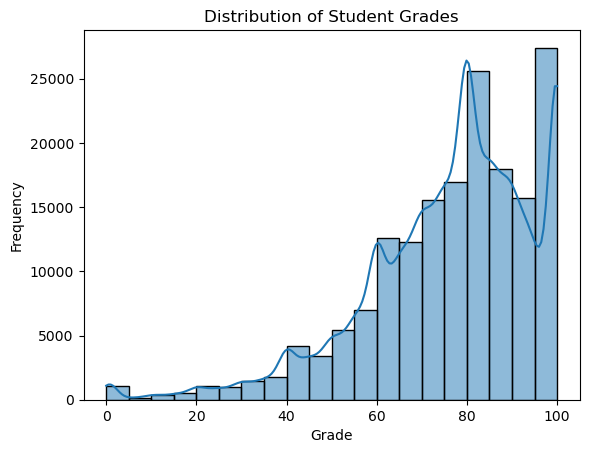

In [13]:
print("\n Visualizations ")
print("Plotting distribution of grades...")
sns.histplot(completed_data['score'], bins=20, kde=True)
plt.title('Distribution of Student Grades')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.show()

# Aggregating VLE interactions on the bases of sum_clicks

In [14]:
print("Aggregating VLE interactions...")
vle_aggregated = reduced_vle.groupby(['id_student', 'code_module'])['sum_click'].sum().reset_index()
vle_aggregated.rename(columns={'sum_click': 'total_clicks'}, inplace=True)

Aggregating VLE interactions...


# Merge VLE interactions

Analyzing VLE impact on grades...


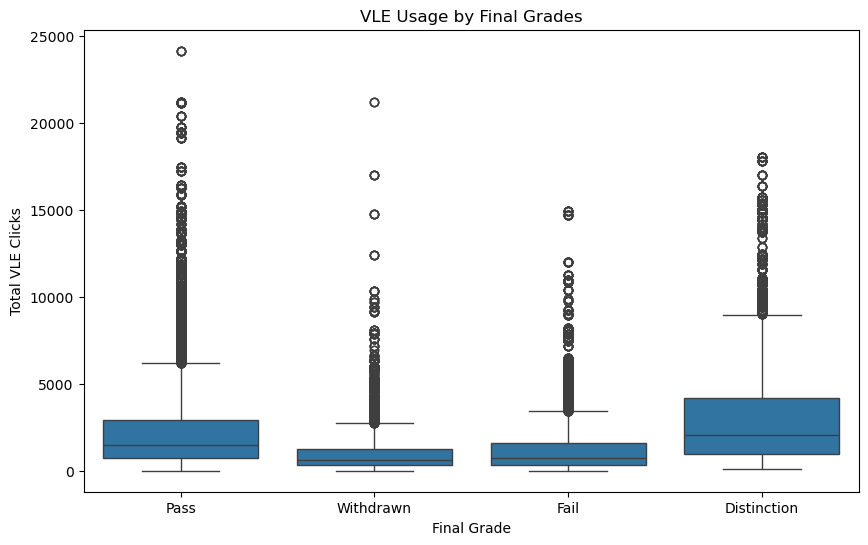

In [15]:
final_data = merged_data.merge(vle_aggregated, on=['id_student', 'code_module'], how='left')
final_data['total_clicks'] = final_data['total_clicks'].fillna(0)

print("Analyzing VLE impact on grades...")
plt.figure(figsize=(10, 6))
sns.boxplot(x='final_result', y='total_clicks', data=final_data)
plt.title('VLE Usage by Final Grades')
plt.xlabel('Final Grade')
plt.ylabel('Total VLE Clicks')
plt.show()

# Hypothesis Testing: Are activity types significantly different?

In [16]:
from scipy.stats import f_oneway
print("Performing hypothesis testing for activity types...")
activity_groups = [group['sum_click'].values for name, group in enriched_student_vle.groupby('activity_type')]
h_stat, p_value = f_oneway(*activity_groups)
print(f"ANOVA Test Statistic: {h_stat:.3f}, P-value: {p_value:.3e}")

# Correlation Analysis: Exploring relationship between clicks and scores
print("Inspecting non-numeric values in the `score` column...")
non_numeric_scores = final_data[~final_data['score'].apply(lambda x: str(x).replace('.', '').isdigit())]
print(f"Non-numeric entries in `score`:\n{non_numeric_scores}")

print("Cleaning and converting `score` column...")
final_data['score'] = pd.to_numeric(final_data['score'], errors='coerce')  # Convert to numeric, replacing invalid values with NaN
final_data['score'] = final_data['score'].fillna(final_data['score'].mean())  # Replace NaN with the mean

print("Analyzing correlation between total clicks and scores...")
correlation = final_data[['total_clicks', 'score']].corr()
print("Correlation Matrix:")
print(correlation)

Performing hypothesis testing for activity types...
ANOVA Test Statistic: 26909.761, P-value: 0.000e+00
Inspecting non-numeric values in the `score` column...
Non-numeric entries in `score`:
        id_assessment  id_student  date_submitted  is_banked score  \
215              1752      721259              22          0     ?   
937              1754      260355             127          0     ?   
2364             1760     2606802             180          0     ?   
3358            14984      186780              77          0     ?   
3914            14984      531205              26          0     ?   
...               ...         ...             ...        ...   ...   
148929          34903      582670             241          0     ?   
159251          37415      610738              87          0     ?   
166390          37427      631786             221          0     ?   
169725          37435      648110              62          0     ?   
170103          37435      480914      

# Visualizing Results

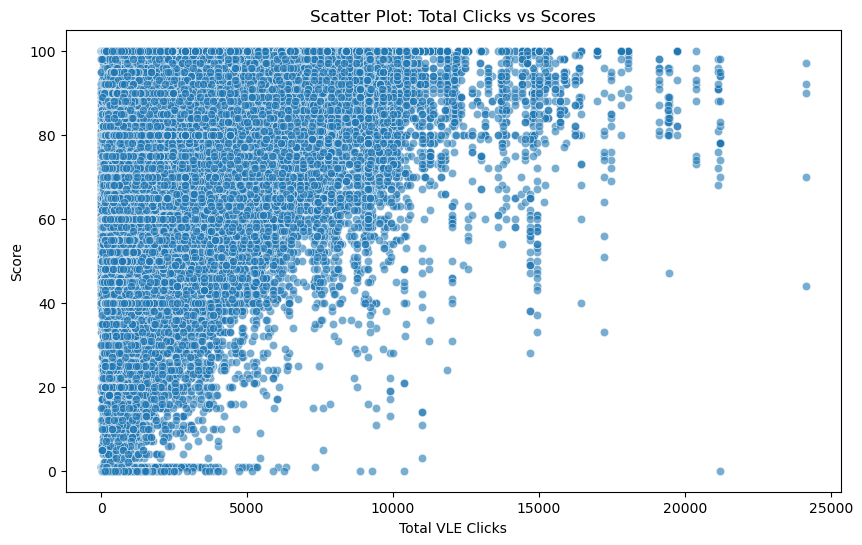

Analysis Complete.


In [17]:
# Visualizing correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_clicks', y='score', data=final_data, alpha=0.6)
plt.title('Scatter Plot: Total Clicks vs Scores')
plt.xlabel('Total VLE Clicks')
plt.ylabel('Score')
plt.show()

print("Analysis Complete.")


# **Question 2: Can we predict students' grades?**

### Preparing features and target variable

In [18]:
print("\n### Predicting Student Grades ###")
print("Preparing features and target variable...")

features = completed_data[['sum_click', 'date_submitted', 'weight']]  
target = completed_data['score']



### Predicting Student Grades ###
Preparing features and target variable...


### Splitting the dataset


In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Model Training and evaluation

In [20]:
#Model Training
print("Training Linear Regression...")
model = LinearRegression()
model.fit(X_train, y_train)
# Model Evaluation
print("Evaluating model...")
y_pred = model.predict(X_test)


Training Linear Regression...
Evaluating model...


# Evaluation Metrics

In [21]:
# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

### Results

Evaluation Results:
Mean Squared Error (MSE): 326.85548606127674
R-squared (R²) Score: 0.060771489029018966
Predictions vs Actual Values:
Predicted: 78.43, Actual: 28.0
Predicted: 75.67, Actual: 100.0
Predicted: 72.33, Actual: 66.0
Predicted: 73.23, Actual: 93.0
Predicted: 72.35, Actual: 87.0


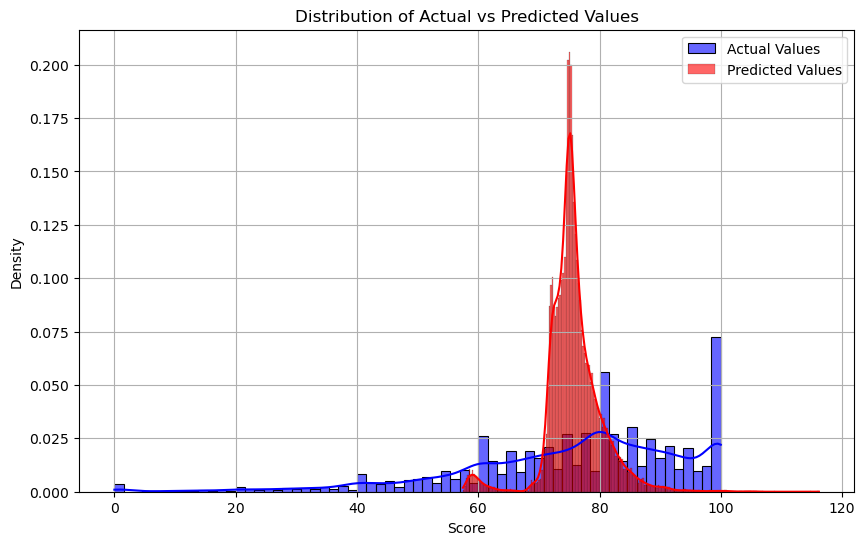

In [23]:
# Results
print("Evaluation Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²) Score: {r2}")

# Optional: Displaying predictions vs actual values
print("Predictions vs Actual Values:")
for i in range(min(5, len(y_test))):  # Display up to 5 examples
    print(f"Predicted: {y_pred[i]:.2f}, Actual: {y_test.iloc[i] if hasattr(y_test, 'iloc') else y_test[i]}")

# Plotting Histogram of Actual vs Predicted Values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, label="Actual Values", color="blue", kde=True, stat="density", alpha=0.6)
sns.histplot(y_pred, label="Predicted Values", color="red", kde=True, stat="density", alpha=0.6)
plt.title("Distribution of Actual vs Predicted Values")
plt.xlabel("Score")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


# Justification for Model Choice
Linear regression was chosen for this task because it is a simple and interpretable model. 
The problem involves predicting a continuous variable, which is suitable for regression analysis. 
Additionally, linear regression aligns with the goal of using "delicate machinery," as emphasized 
by the professor, ensuring we focus on interpretability and simplicity rather than complexity.


# Feature Selection
Feature selection is a crucial step to ensure that only relevant predictors are included in the model. 
Here, features were selected based on their correlation with the target variable and domain knowledge. 
Features with high correlation and significance to the task were retained, while others were excluded to 
avoid multicollinearity and overfitting.



# Limitations of the Model
1. **Dataset Quality:** The dataset might contain missing values, outliers, or imbalanced distributions, 
   which can affect model performance.
2. **Model Assumptions:** Linear regression assumes linearity between predictors and the target variable, 
   which may not hold true in real-world data.
3. **Overfitting/Underfitting:** The model might underperform if important features are excluded or overfit 
   if irrelevant features are included.
4. **Scalability:** Linear regression may not perform well on large datasets or datasets with complex 
   interactions between variables.



# Interpretation of Results
The model was evaluated using Mean Squared Error (MSE) and R-squared (R²) metrics:

- **MSE:** Measures the average squared difference between the actual and predicted values. Lower values 
  indicate better fit.
- **R² Score:** Indicates the proportion of variance in the target variable explained by the model. 
  Higher values indicate better performance.

These metrics help assess the goodness-of-fit of the model. The histogram comparing actual and predicted 
values further illustrates how well the model captures the data distribution.
